<a href="https://colab.research.google.com/github/blakelobato/DS-Unit-4-Sprint-3-Deep-Learning/blob/master/4_3_Sprint_Challenge_BL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Major Neural Network Architectures Challenge
## *Data Science Unit 4 Sprint 3 Challenge*

In this sprint challenge, you'll explore some of the cutting edge of Data Science. This week we studied several famous neural network architectures: 
recurrent neural networks (RNNs), long short-term memory (LSTMs), convolutional neural networks (CNNs), and Autoencoders. In this sprint challenge, you will revisit these models. Remember, we are testing your knowledge of these architectures not your ability to fit a model with high accuracy. 

__*Caution:*__  these approaches can be pretty heavy computationally. All problems were designed so that you should be able to achieve results within at most 5-10 minutes of runtime locally, on AWS SageMaker, on Colab or on a comparable environment. If something is running longer, double check your approach!

## Challenge Objectives
*You should be able to:*
* <a href="#p1">Part 1</a>: Train a LSTM classification model
* <a href="#p2">Part 2</a>: Utilize a pre-trained CNN for object detection
* <a href="#p3">Part 3</a>: Describe a use case for an autoencoder
* <a href="#p4">Part 4</a>: Describe yourself as a Data Science and elucidate your vision of AI

In [1]:
# Check that we have a GPU instance of Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon May  4 01:42:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

<a id="p1"></a>
## Part 1 - LSTMSs

Use a LSTM to fit a multi-class classification model on Reuters news articles to distinguish topics of articles. The data is already encoded properly for use in a LSTM model. 

Your Tasks: 
- Use Keras to fit a predictive model, classifying news articles into topics. 
- Report your overall score and accuracy

For reference, the [Keras IMDB sentiment classification example](https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py) will be useful, as well as the LSTM code we used in class.

__*Note:*__  Focus on getting a running model, not on maxing accuracy with extreme data size or epoch numbers. Only revisit and push accuracy if you get everything else done!

In [0]:
import pandas as pd
import numpy as np
import random
import sys
import os
import tensorflow
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, MaxPooling1D, PReLU, Flatten

In [0]:
from tensorflow.keras.datasets import reuters

(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=None,
                                                         skip_top=0,
                                                         maxlen=None,
                                                         test_split=0.2,
                                                         seed=723812,
                                                         start_char=1,
                                                         oov_char=2,
                                                         index_from=3)

In [7]:
# Concatonate test and training datasets
allreviews = np.concatenate((X_train, X_test), axis=0)

# Review lengths across test and training whole datasets
print("Maximum review length: {}".format(len(max((allreviews), key=len)))) #length cuz words are integers
print("Minimum review length: {}".format(len(min((allreviews), key=len))))
result = [len(x) for x in allreviews]
print("Mean review length: {}".format(np.mean(result))) #normalize length of reviews in process

# Print a review and it's class as stored in the dataset. Replace the number
# to select a different review.
print("")
print("Machine readable Review")
print("  Review Text: " + str(X_train[60])) #testing showing 60'th review 
print("  Review Sentiment: " + str(y_train[60]))


Maximum review length: 2376
Minimum review length: 2
Mean review length: 145.96419665122906

Machine readable Review
  Review Text: [1, 53, 46, 160, 26, 14, 74, 142, 26, 39, 46, 4312, 4938, 14, 74, 957, 4835, 86, 19, 445, 18, 14, 32, 451, 18, 17, 12]
  Review Sentiment: 3


In [9]:
# If you want to pad the end of the sequences you can set padding='post'.
maxlen = 200 #try to limit to 300 words cuz like 70% of reviews and shorten the rest with 1000 words or something
#not to mention 300 words most likely gunna havce the negative shit
#value impacts nn later on


#pad sequences
print('Pad Sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=maxlen) #takes sequences in and normalize them to length 300
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print('x_train shape: ', X_train.shape)
print('x_test shape: ', X_test.shape)

Pad Sequences (samples x time)
x_train shape:  (8982, 200)
x_test shape:  (2246, 200)


In [10]:
# Demo of encoding

word_index = reuters.get_word_index(path="reuters_word_index.json")

print(f"Iran is encoded as {word_index['iran']} in the data")
print(f"London is encoded as {word_index['london']} in the data")
print("Words are encoded as numbers in our dataset.")

Iran is encoded as 779 in the data
London is encoded as 544 in the data
Words are encoded as numbers in our dataset.


In [0]:
# Do not change this line. You need the +1 for some reason. 
max_features = len(word_index.values()) + 1

# TODO - your code!


In [12]:
#see max amount of features
max_features

30980

In [13]:
# get number of classes to return
numbered_classes = max(y_train) + 1
print(numbered_classes)

46


In [16]:
#batch size for the articles
batch_size = 32
print(batch_size)

32


In [21]:
#build LSTM model
lstm = Sequential()
lstm.add(Embedding(max_features, 128))
lstm.add(LSTM(128, return_sequences=True)) #now lstm layer
lstm.add(Dropout(0.20))
lstm.add(LSTM(128)) #if two lstm layers need return sequences up there
lstm.add(Dropout(0.20))
lstm.add(Dense(numbered_classes, activation='softmax'))

lstm.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam', 
             metrics=['accuracy'])

lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         3965440   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 46)                5934      
Total params: 4,234,542
Trainable params: 4,234,542
Non-trainable params: 0
____________________________________________

In [0]:
#add early stopping
stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5)

In [28]:
lstm_hist = lstm.fit(X_train, y_train, batch_size=batch_size, epochs=25, validation_data=(X_test, y_test), callbacks=[stop])


Epoch 1/25
281/281 [==============================] - 18s 62ms/step - loss: 0.7080 - accuracy: 0.8146 - val_loss: 1.5068 - val_accuracy: 0.6572
Epoch 2/25
281/281 [==============================] - 18s 62ms/step - loss: 0.6177 - accuracy: 0.8357 - val_loss: 1.4437 - val_accuracy: 0.6790
Epoch 3/25
281/281 [==============================] - 16s 59ms/step - loss: 0.5506 - accuracy: 0.8549 - val_loss: 1.6032 - val_accuracy: 0.6474
Epoch 4/25
281/281 [==============================] - 16s 59ms/step - loss: 0.5061 - accuracy: 0.8656 - val_loss: 1.4429 - val_accuracy: 0.6759
Epoch 5/25
281/281 [==============================] - 17s 61ms/step - loss: 0.4368 - accuracy: 0.8857 - val_loss: 1.5143 - val_accuracy: 0.6839
Epoch 6/25
281/281 [==============================] - 17s 59ms/step - loss: 0.4307 - accuracy: 0.8843 - val_loss: 1.5146 - val_accuracy: 0.6763
Epoch 7/25
281/281 [==============================] - 17s 59ms/step - loss: 0.3696 - accuracy: 0.9022 - val_loss: 1.5386 - val_accuracy:

In [0]:
acc_train = 92.75

In [32]:
score, acc = lstm.evaluate(X_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

71/71 [==============================] - 1s 9ms/step - loss: 1.7309 - accuracy: 0.6541
Test score: 1.7308952808380127
Test accuracy: 0.654051661491394


In [0]:
acc = acc*100

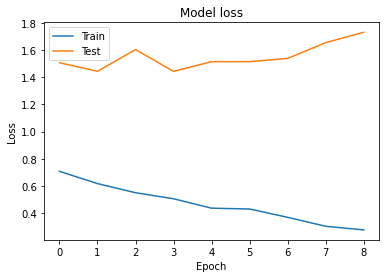

In [30]:
# Plot training & validation loss values
import matplotlib.pyplot as plt

plt.plot(lstm_hist.history['loss'])
plt.plot(lstm_hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

In [37]:
print('We were able to get ~65% accuracy on the training data actual:', acc_train)
print('We were able to get ~67% accuracy on the test data actual:', acc)

We were able to get ~65% accuracy on the training data actual: 92.75
We were able to get ~67% accuracy on the test data actual: 65.4051661491394


## Sequence Data Question
#### *Describe the `pad_sequences` method used on the training dataset. What does it do? Why do you need it?*
- pad_sequences does exactly what it sounds like... It pads sequences to the same length. This helps the LSTM take in the same shape it expects for each entry. This transforms our numpy list of integers into a 2-D array. If they are too small they are given zeros at the end and if they are too long they are truncated.



## RNNs versus LSTMs
#### *What are the primary motivations behind using Long-ShortTerm Memory Cell unit over traditional Recurrent Neural Networks?*
- LSTM uses the forget functionality which is different than traditional Recurrent Neural Networks. This is a way to be stronger than RNNs in accuracy metrics in some cases due to the fact tht LSTM's can forget aspects that don't help promote overall success whereras RNNs are unable to do so, thus carrying values that don't push towards a maximum accuracy. LSTMs can put more emphasis on a value that it recently found to help greatly over values it has previously learned does not help as well.



## RNN / LSTM Use Cases
#### *Name and Describe 3 Use Cases of LSTMs or RNNs and why they are suited to that use case*
- Text Classifcation
- Text Generation
- Video Classification/Image Captioning
- Time Series Data Forecasting or Sequential data analysis


<a id="p2"></a>
## Part 2- CNNs

### Find the Frog

Time to play "find the frog!" Use Keras and [ResNet50v2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet_v2) (pre-trained) to detect which of the images with the `frog_images` subdirectory has a frog in it. Note: You will need to upload the images to Colab. 

<img align="left" src="https://d3i6fh83elv35t.cloudfront.net/newshour/app/uploads/2017/03/GettyImages-654745934-1024x687.jpg" width=400>

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from skimage.io import imread_collection
from skimage.transform import resize
from sklearn.model_selection import train_test_split

In [0]:
test_images = '/content/drive/My Drive/Colab Notebooks/Unit 4 Sprint 3 Major NN Arch/U4S3 Challenge 3/BulkResizePhotos/*.jpg'
#creating a collection with the available images
X_test = imread_collection(test_images).concatenate()

In [185]:
X_test.shape

(15, 600, 800, 3)

In [0]:
model = ResNet50V2(weights='imagenet')

In [0]:
X_test = preprocess_input(X_test)

In [0]:
predictions = model.predict(X_test)

In [0]:
labels = decode_predictions(predictions) 

In [202]:
labels

[[('n07613480', 'trifle', 1.0),
  ('n15075141', 'toilet_tissue', 0.0),
  ('n02317335', 'starfish', 0.0),
  ('n02391049', 'zebra', 0.0),
  ('n02389026', 'sorrel', 0.0)],
 [('n07613480', 'trifle', 1.0),
  ('n15075141', 'toilet_tissue', 0.0),
  ('n02317335', 'starfish', 0.0),
  ('n02391049', 'zebra', 0.0),
  ('n02389026', 'sorrel', 0.0)],
 [('n02356798', 'fox_squirrel', 1.0),
  ('n02089973', 'English_foxhound', 2.6367866e-33),
  ('n15075141', 'toilet_tissue', 0.0),
  ('n02321529', 'sea_cucumber', 0.0),
  ('n02395406', 'hog', 0.0)],
 [('n02356798', 'fox_squirrel', 1.0),
  ('n07613480', 'trifle', 1.4100145e-10),
  ('n02089973', 'English_foxhound', 9.574201e-21),
  ('n15075141', 'toilet_tissue', 0.0),
  ('n02317335', 'starfish', 0.0)],
 [('n07613480', 'trifle', 1.0),
  ('n15075141', 'toilet_tissue', 0.0),
  ('n02317335', 'starfish', 0.0),
  ('n02391049', 'zebra', 0.0),
  ('n02389026', 'sorrel', 0.0)],
 [('n02089973', 'English_foxhound', 0.99968433),
  ('n02356798', 'fox_squirrel', 0.00031564

# Once resizing images they came as trifle, or fox_squirrel, etc. So they need to be reshaped for further analysis.

The skimage function below will help you read in all the frog images into memory at once. You should use the preprocessing functions that come with ResnetV2 to help resize the images prior to inference. 

In [0]:
from skimage.io import imread_collection

#images = imread_collection('./frog_images/*.jpg')
images = imread_collection('/content/drive/My Drive/Colab Notebooks/Unit 4 Sprint 3 Major NN Arch/U4S3 Challenge 3/frog_images/*.jpg')

In [164]:
print(type(images))
print(type(images[0]), end="\n\n")

<class 'skimage.io.collection.ImageCollection'>
<class 'numpy.ndarray'>



In [46]:
images[1].shape

(3810, 2856, 3)

In [55]:
images[2].shape

(3456, 4608, 3)

In [54]:
images[3].shape

(2500, 3335, 3)

In [56]:
images[4].shape

(2000, 3008, 3)

In [57]:
images[5].shape

(2883, 4319, 3)

In [58]:
images[6].shape

(4000, 6000, 3)

In [60]:
images[7].shape

(2642, 3918, 3)

In [61]:
images[8].shape

(3456, 5184, 3)

In [62]:
images[9].shape

(2912, 4368, 3)

In [65]:
images[10].shape

(4928, 3285, 3)

In [64]:
images[11].shape

(3702, 5397, 3)

In [66]:
images[12].shape

(1856, 2784, 3)

In [67]:
images[13].shape

(2592, 3872, 3)

In [68]:
images[14].shape

(2673, 3382, 3)

In [47]:
len(images)

15

In [0]:
image_list = []
resized_list = []

In [0]:
image_list = []
resized_list = []
for image in images:
  image = resize(image, (256,256,3))
  #image = image.resize((1500, 1500, 3))
  resized_list.append(image)

In [169]:
resized_list

[array([[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157]],
 
        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157]],
 
        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157]],
 
        ...,
 
        [[0.08235294, 0.08627451, 0.0627451 ],
         [0.06344063, 0.0673622 , 0.04383

Your goal is to validly run ResNet50v2 on the input images - don't worry about tuning or improving the model. Print out the predictions in any way you see fit. 

*Hint* - ResNet 50v2 doesn't just return "frog". The three labels it has for frogs are: `bullfrog, tree frog, tailed frog`

*Stretch goals:* 
- Check for other things such as fish.
- Print out the image with its predicted label
- Wrap everything nicely in well documented fucntions

In [0]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, decode_predictions, preprocess_input
# TODO - your code!


In [0]:
# Create the base model from the pre-trained model ResNet
#input_shape= (256,256,3)
base_model = tensorflow.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(256,256,3))

for layer in base_model.layers:
    layer.trainable = False

In [0]:
base_model.trainable = False

In [113]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

# Could use more time on this part but was able to run tghrough. Looks like resizing hte images could have messed up accuracy.

<a id="p3"></a>
## Part 3 - Autoencoders

Describe a use case for an autoencoder given that an autoencoder tries to predict its own input. 

__*Your Answer:*__ 
An autoencoder is really good for denoising an image. The *encoder* compresses the input data and the *decoder* does the reverse to produce the uncompressed version of the data to create a reconstruction of the input as accurately as possible. 

They are aalso good for image retrival where they can reverse image search for similar images.

<a id="p4"></a>
## Part 4 - More...

Answer the following questions, with a target audience of a fellow Data Scientist:

- What do you consider your strongest area, as a Data Scientist?
  - My strongest skillset as a data scientist is my classification and regression machine learning predictions with Flask application components. I think this sets me apart from most as I am able to understand how to implement a classification problem with a user friendly application to back it.
- What area of Data Science would you most like to learn more about, and why?
  - I want to dive deeper into NN architectures and formats. I feel there is so much undernearth the hood going on that I can learn more about and possibly implement into other areas outside of data science. I want to also experiment with GPU's and become a more invested data scientist.
- Where do you think Data Science will be in 5 years?
  - I think the industry of Data Science as a whole is continuing to bloom and can only grow in size and areas. I hope to be involved in system analytics and system analysis for space vehicles in the next five years. That is my dream field and feel there are many aspects in which I can contribute to in that industry.
- What are the threats posed by AI to our society?
  - I think job loss is a big issue that is factored into AI and then morality of how that AI will act or be unguarded with personal/important information it oversees. (Can not accidentally send out information or delete critical components) I also think another issue is legality of autonomous vehicles like Tesla or Bell (producing uber planes with some AI features) this could lead to some problems if an accident or malfunction occured. 
- How do you think we can counteract those threats? 
  - Obviously some of these problems are not really at the for front but are issues we can really get ourselves stuck in down the road. I think safety procautions, backups, and checks are critical to seeing information stored and saved properly. I also think AI for innovation can provide jobs in other ways so pushing for a better future is important too.
- Do you think achieving General Artifical Intelligence is ever possible?
  - Never say never lol! But I would be interested to see what does come of it. It may be doable in time but I do not know.


A few sentences per answer is fine - only elaborate if time allows.

## Congratulations! 

Thank you for your hard work, and congratulations! You've learned a lot, and you should proudly call yourself a Data Scientist.


In [38]:
from IPython.display import HTML

HTML("""<iframe src="https://giphy.com/embed/26xivLqkv86uJzqWk" width="480" height="270" frameBorder="0" class="giphy-embed" allowFullScreen></iframe><p><a href="https://giphy.com/gifs/mumm-champagne-saber-26xivLqkv86uJzqWk">via GIPHY</a></p>""")